# Ideal vs Noisy Bell State with Aer (density_matrix) — Problem & Concepts

**Goal.** Build a 2-qubit Bell circuit, run it **ideally** (no noise) and then **with a realistic noise model**, and compare their measurement distributions.

**Circuit.**  
`H(0) → CX(0,1) → measure(0,1)` prepares the Bell state  
\\[
|\Phi^+\rangle=\tfrac{1}{\sqrt{2}}(|00\rangle+|11\rangle).
\\]
In the **ideal** case, measurements return only `00` or `11` with ~50/50 probability.

**Two simulators.**
- **Ideal:** `AerSimulator(method='statevector')`: pure, noiseless evolution.
- **Noisy:** `AerSimulator(method='density_matrix')`: required for **non-unitary channels** (noise that creates mixed states).

**Noise model (what we include).**
1. **Thermal relaxation (T₁/T₂)** during gates:
   - 1-qubit: `sx`, `x` (Hadamard decomposes into `rz`+`sx`, so this matters).
   - 2-qubit: `cx` (modelled as relaxation on both qubits over the CX duration).
2. **Depolarizing noise:** small random Pauli errors on 1q/2q gates.
3. **Readout error:** imperfect measurement (confusion matrix per qubit).

**Timings and parameters.**
- Gate durations (example transmon-like): `t_sx ≈ 35 ns`, `t_x ≈ 70 ns`, `t_cx ≈ 300 ns`.
- Relaxation times: `T₁ ≈ 60 µs`, `T₂ ≈ 80 µs`.  
- Seeds and shots are set for reproducibility and clear statistics.

**What to expect.**
- **Ideal run:** ~50% `00`, ~50% `11`.  
- **Noisy run:** probability **shifts toward `00`** (relaxation drives |1⟩→|0⟩), with small population in `01`/`10` (from depolarizing and readout error).  
- Optional bar plots visualize the distributions, like the figures in the book.


Original circuit:
     ┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1 

Ideal counts (no noise):
{'00': 2052, '11': 2044}

Noisy counts (density_matrix + thermal + depolarizing + readout):
{'01': 219, '10': 247, '00': 1908, '11': 1722}


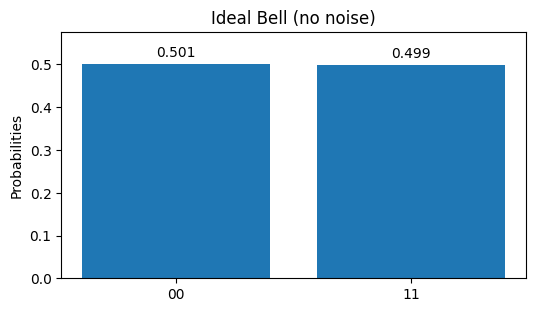

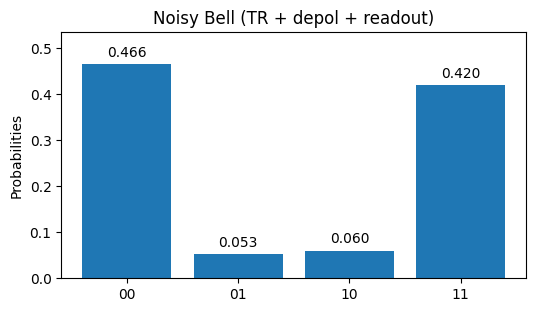


Noisy per-shot memory (first 16 shots):
['11', '11', '00', '00', '11', '11', '11', '00', '11', '11', '00', '00', '11', '00', '10', '11']


In [23]:
"""
One-cell, fully commented demo: Ideal vs Noisy Bell State with a Realistic Noise Model (Qiskit 2.x)

What this cell demonstrates — end to end:
  1) Build a minimal 2-qubit Bell circuit: H on q0, CX(0→1), then measure both qubits.
  2) Run it on an *ideal* (noiseless) statevector simulator as a clean baseline.
  3) Build a *device-like* noise model that includes:
       • Thermal relaxation (T1/T2) acting during gate execution windows (sx/x and cx),
       • Small depolarizing noise on 1-qubit and 2-qubit gates,
       • Per-qubit readout error via a confusion matrix.
     (We pick plausible transmon-style gate times and coherence values.)
  4) Run the same circuit on a *density-matrix* simulator (needed for non-unitary noise channels).
  5) Compare measurement outcomes (counts) between ideal vs noisy runs, draw simple probability bars,
     and optionally print per-shot memory from the noisy run to see raw bitstrings.

Key concepts tied to the code:
  • Statevector vs density-matrix: Non-unitary channels (relaxation, readout) turn pure states into *mixed* states,
    so we must use a density-matrix method to model them correctly.
  • Gate-duration awareness: Thermal relaxation depends on how long gates take (t_sx, t_x, t_cx).
  • Two-qubit gates dominate error: Longer duration → more opportunity for T1/T2 decay → observable bias toward '00'.
  • Readout error vs gate error: Off-diagonal outcomes ('01','10') can be caused by both; try toggling each source to isolate effects.

Tweak ideas to explore:
  • Increase t_cx or decrease T1/T2 to amplify relaxation (probability mass drifts to '00').
  • Comment out readout or depolarizing lines to isolate specific error sources.
  • Raise SHOTS for smoother (lower-variance) probability bars.
"""

# ── Imports ─────────────────────────────────────────────────────────────────────
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, depolarizing_error
from qiskit_aer.noise.errors import ReadoutError

import numpy as np
import matplotlib.pyplot as plt

# ── Configuration (reproducibility & quick toggles) ─────────────────────────────
SEED  = 7       # control stochastic choices (transpiler/PRNG)
SHOTS = 4096    # number of samples drawn for each run
SHOW_PLOTS = True  # set False to skip plotting bar charts

# ── Helper: from 'counts' -> probability bar plot (matplotlib defaults, no styling) ─
def plot_probs(counts, title=""):
    """
    Plot a minimal bar chart of probabilities from a counts dict.
    We intentionally avoid specifying colors or styles (keep defaults).
    """
    # Stable x-axis ordering for readability
    keys = sorted(counts.keys())
    vals = np.array([counts[k] for k in keys], dtype=float)
    total = max(1.0, vals.sum())   # guard against division by zero
    probs = vals / total

    plt.figure(figsize=(6, 3.2))
    plt.bar(range(len(keys)), probs)                    # default color; no custom style
    plt.xticks(range(len(keys)), keys)
    # Leave headroom for numeric labels above bars
    plt.ylim(0, max(0.32, probs.max() * 1.15))
    for i, p in enumerate(probs):
        plt.text(i, p + 0.01, f"{p:.3f}", ha="center", va="bottom")
    plt.ylabel("Probabilities")
    plt.title(title)
    plt.show()

# ── (1) Build a minimal Bell circuit ────────────────────────────────────────────
# Start in |00>. Apply H on q0 → (|0>+|1>)/√2 on q0. CX(0→1) entangles → Bell state.
# Measure both qubits into classical bits of the same indices.
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

print("Original circuit:")
print(qc.draw(fold=120))

# ── (2) Ideal simulator (no noise) as baseline ──────────────────────────────────
# Statevector method yields the exact pure state evolution (sampling only happens at measurement).
ideal_sim = AerSimulator(method='statevector')

# ── (3) Build a realistic noise model (thermal + depolarizing + readout) ───────
noise = NoiseModel()

# Gate durations (seconds): plausible transmon-like numbers.
#   Why we care: thermal relaxation acts *during* these windows, so longer gates → more decay.
t_sx = 35e-9    # ~35 ns for √X
t_x  = 70e-9    # ~70 ns for X
t_cx = 300e-9   # ~300 ns for a 2-qubit entangling gate (e.g., CX/ECR wrapper)

# Coherence times (seconds): example values; adjust to explore behavior.
T1 = 60e-6      # energy relaxation time |1>→|0>
T2 = 80e-6      # dephasing time

# Thermal relaxation channels:
#   • For 1-qubit gates (sx/x), add a 1-qubit CPTP channel per qubit.
#   • For the 2-qubit CX, model relaxation on both qubits over the same time window by tensoring.
err_sx_1q = thermal_relaxation_error(T1, T2, t_sx)
err_x_1q  = thermal_relaxation_error(T1, T2, t_x)
err_cx_2q = thermal_relaxation_error(T1, T2, t_cx).tensor(
            thermal_relaxation_error(T1, T2, t_cx)
          )

# Attach 1-qubit thermal errors to *all* qubits for these instructions.
# Note: H is not a native gate; it decomposes into rz + sx on many IBMQ bases.
#       rz is a virtual frame shift (no duration), so relaxation on 'sx' is the relevant piece.
noise.add_all_qubit_quantum_error(err_sx_1q, ['sx'])
noise.add_all_qubit_quantum_error(err_x_1q,  ['x'])

# Attach 2-qubit thermal error to the CX pair (0,1). Order [0,1] matters for book-keeping, not physics.
noise.add_quantum_error(err_cx_2q, ['cx'], [0, 1])

# Add small depolarizing noise (order-of-magnitude typical for demos).
#   • 1e-3 on 1-qubit gates,
#   • 5e-3 on 2-qubit gates (usually noisier in practice).
noise.add_all_qubit_quantum_error(depolarizing_error(1e-3, 1), ['sx', 'x'])
noise.add_quantum_error(depolarizing_error(5e-3, 2), ['cx'], [0, 1])

# Readout error per qubit via a 2×2 confusion matrix:
#   rows = true state (0,1), cols = reported state (0,1).
#   Here: P(0|0)=0.96, P(1|0)=0.04, P(0|1)=0.08, P(1|1)=0.92
readout = ReadoutError([[0.96, 0.04],
                        [0.08, 0.92]])
noise.add_all_qubit_readout_error(readout)

# ── (4) Noisy simulator (density_matrix supports non-unitary channels) ──────────
# The density-matrix method tracks mixed states created by noise channels and readout.
noisy_sim = AerSimulator(method='density_matrix', noise_model=noise)

# ── (5) Transpile per backend, run both, and compare ────────────────────────────
# Why transpile twice? Each backend (ideal vs noisy) may expose different native bases / timing models.
qc_ideal = transpile(qc, ideal_sim, seed_transpiler=SEED)
qc_noisy = transpile(qc, noisy_sim, seed_transpiler=SEED)

# Execute both runs with the same number of shots and seed for the simulator RNG.
res_ideal = ideal_sim.run(qc_ideal, shots=SHOTS, seed_simulator=SEED).result()
res_noisy = noisy_sim.run(qc_noisy, shots=SHOTS, seed_simulator=SEED).result()

# Extract histograms (bitstring → count). Keys are strings like '00','11', etc.
counts_ideal = res_ideal.get_counts()
counts_noisy = res_noisy.get_counts()

print("\nIdeal counts (no noise):")
print(counts_ideal)  # Expect ~50/50 between '00' and '11' (Bell state).

print("\nNoisy counts (density_matrix + thermal + depolarizing + readout):")
print(counts_noisy)  # Typically biased toward '00' with small weight in '01'/'10'.

# Optional: simple probability bar plots (kept intentionally plain for clarity).
if SHOW_PLOTS:
    plot_probs(counts_ideal, "Ideal Bell (no noise)")
    plot_probs(counts_noisy, "Noisy Bell (TR + depol + readout)")

# ── (6) Optional: per-shot memory preview for the noisy run ─────────────────────
# Useful to see raw shot strings in order (e.g., for debugging or time-ordered analyses).
res_noisy_small = noisy_sim.run(qc_noisy, shots=16, memory=True, seed_simulator=SEED).result()
print("\nNoisy per-shot memory (first 16 shots):")
print(res_noisy_small.get_memory(qc_noisy))

# ── Notes for further exploration ───────────────────────────────────────────────
# • Comment out the readout lines to observe gate-noise effects without measurement error.
# • Comment out depolarizing to isolate the effect of thermal relaxation alone (bias → '00').
# • Change t_cx (e.g., to 500e-9) or T1/T2 (e.g., to 30e-6/40e-6) and re-run to see stronger drift.
# • Increase SHOTS (e.g., 20_000) for smoother bars; decrease for a quick preview.


# Results & Interpretation

**Baseline (ideal).**  
Counts should be split between `00` and `11` (~50/50). Any small imbalance is just sampling noise.

**Noisy run — what the changes mean.**
- **More `00`:** Thermal relaxation (finite T₁/T₂) during `sx/x/cx` and idle periods pushes excited states toward `|0⟩`. The longer the **CX duration** or the smaller T₁/T₂, the stronger this drift.
- **Some `01`/`10`:**  
  - **Depolarizing** injects random Pauli errors, spreading probability into the off-diagonal outcomes.  
  - **Readout error** flips some shots at measurement time, further populating `01`/`10`.
- **`11` decreases:** Both relaxation and readout error reduce the chance of seeing two perfect `1`s simultaneously.

**Quick sanity checks.**
- Comment out **readout error** → `01`/`10` should shrink, but not vanish (gate noise remains).  
- Comment out **depolarizing** → off-diagonal outcomes shrink further; bias to `00` persists (relaxation).  
- Increase `t_cx` or reduce `T₁/T₂` → stronger skew to `00`.  
- Increase `SHOTS` → bar heights stabilize (less sampling variance).

**Takeaways.**
- **Two-qubit gates dominate** noise impact: their longer duration amplifies relaxation effects.  
- **Density-matrix simulation** is essential here; non-unitary channels create mixed states that a pure statevector can’t represent.  
- The gap between ideal and noisy counts provides an intuition for **device-level error sources** (gate duration vs coherence, depolarizing, and readout).

**What to report (typical lab notes).**
- Gate times (`t_sx, t_x, t_cx`), T₁/T₂ used, depolarizing probabilities, readout matrix, seeds, and shots.  
- Side-by-side histograms for ideal vs noisy runs and a brief rationale for observed shifts.


In [14]:
# Core Qiskit classes
from qiskit import QuantumCircuit

# Sampler-style simulator (draws measurement samples a.k.a. "shots")
from qiskit_aer import QasmSimulator

# Utilities
import numpy as np
import matplotlib.pyplot as plt

# Global knobs
SHOTS = 1024
SIM = QasmSimulator()  # local simulator that returns bitstring samples

def run_counts(circ, shots=SHOTS):
    """
    Execute `circ` on the QasmSimulator and return a counts dictionary:
    e.g., {'0010': 253, '0110': 255, ...}
    """
    # We can pass circuits directly to run(); transpile is implicit for this simple use.
    result = SIM.run(circ, shots=shots, memory=False).result()
    return result.get_counts(circ)

def plot_probs(counts, title=""):
    """
    Render a simple probability bar chart from a counts dict using matplotlib
    (keeps to default colors; no styling assumptions).
    """
    # Sort keys for a stable left-to-right order on the x-axis
    keys = sorted(counts.keys())
    vals = np.array([counts[k] for k in keys], dtype=float)
    probs = vals / vals.sum()  # normalize to probabilities

    plt.figure(figsize=(6, 3.2))
    plt.bar(range(len(keys)), probs)  # default color (per instructions)
    plt.xticks(range(len(keys)), keys)
    plt.ylim(0, max(0.32, probs.max() * 1.15))  # headroom for value labels
    plt.ylabel("Probabilities")
    plt.title(title)

    # Numeric labels above bars
    for ix, p in enumerate(probs):
        plt.text(ix, p + 0.01, f"{p:.3f}", ha="center", va="bottom")
    plt.show()


Decomposed circuit for 2Q initialize:
          ┌─────────────────────────────────────────┐┌─┐   
q_0: ─|0>─┤0                                        ├┤M├───
          │  State Preparation(0.70711,0,0,0.70711) │└╥┘┌─┐
q_1: ─|0>─┤1                                        ├─╫─┤M├
          └─────────────────────────────────────────┘ ║ └╥┘
c: 2/═════════════════════════════════════════════════╩══╩═
                                                      0  1 
Counts: {'11': 516, '00': 508}


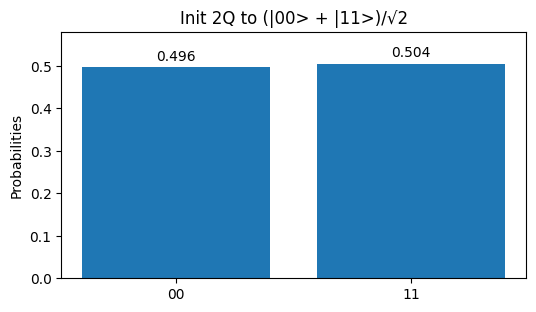

In [22]:
"""
Prepare-and-measure a Bell-like state *directly* via `initialize` (no H+CX),
then sample outcomes and visualize their probabilities.

Concept:
- `initialize(state, qubits)` takes a normalized statevector and prepares the
  listed qubits in that state. For 2 target qubits, the vector length must be 4.
- Qiskit uses little-endian ordering for basis states on the *qubit list you pass*.
  For `initialize(state, [0, 1])`, the statevector components are ordered as:
      [ |q1 q0> ] = [ |00>, |01>, |10>, |11> ].
- Measuring both qubits maps quantum bits to classical bits; `get_counts` will
  report bitstrings in the order of the classical registers (highest index on
  the left). With `measure([0,1],[0,1])`, the printed string is c1 c0 (i.e., q1 q0).

Prereqs:
- Assumes you already defined `run_counts(circ)` and `plot_probs(counts, title)`
  (e.g., from earlier cells). If not, you can quickly create them:
    from qiskit_aer import QasmSimulator
    SIM = QasmSimulator()
    def run_counts(c, shots=1024): return SIM.run(c, shots=shots).result().get_counts(c)
    def plot_probs(counts, title=""): ...  # any simple matplotlib bar plot
"""

# --- Imports (safe to re-import; remove if already present) ---
import numpy as np
from qiskit import QuantumCircuit

# --- 1) Define the target 2-qubit statevector -----------------
# Target state: (|00> + |11>) / sqrt(2)
# Basis order for `initialize(state, [0,1])` is [|00>, |01>, |10>, |11>].
state_bell_like = np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2)

# Sanity checks (recommended for learning/debugging):
assert state_bell_like.shape == (4,), "Statevector must have length 4 for 2 qubits."
# Normalization: sum |amp|^2 must be 1
assert np.isclose(np.vdot(state_bell_like, state_bell_like).real, 1.0, atol=1e-12), \
       "Statevector is not normalized."

# --- 2) Build a 2-qubit circuit with 2 classical bits ----------
qc_init = QuantumCircuit(2, 2)

# Initialize BOTH qubits [0,1] to the given 2-qubit state.
# Notes:
# - On simulators, this sets the state exactly.
# - On real hardware, the transpiler will decompose this into a *long* sequence of gates.
qc_init.initialize(state_bell_like, [0, 1])

# Map quantum measurements to classical bits *in the same order*.
# After this, get_counts will print strings as c1 c0 (i.e., q1 q0).
qc_init.measure([0, 1], [0, 1])

# --- 3) (Optional) Inspect the synthesized gate sequence -------
# `initialize` is not a primitive gate; this shows the decomposition that would run.
print("Decomposed circuit for 2Q initialize:")
print(qc_init.decompose().draw(fold=120))

# --- 4) Execute and visualize ---------------------------------
# `run_counts` should execute on a sampling simulator (e.g., QasmSimulator)
# and return a dict like {'00': ~N/2, '11': ~N/2}.
counts_2q = run_counts(qc_init)
print("Counts:", counts_2q)

# Plot a simple probability bar chart (e.g., like the book’s figures)
plot_probs(counts_2q, "Init 2Q to (|00> + |11>)/√2")

# Expected outcome (ideal simulation):
# - Only '00' and '11' should appear, each with ~50% probability (up to sampling noise).
# If you see '01' or '10', verify that you're on an ideal simulator with no noise model,
# and double-check the statevector ordering and measurement mapping.


Decomposed circuit for partial (3/4) initialize:
                                                          ░ ┌─┐         
q_0: ─────────────────────────────────────────────────────░─┤M├─────────
          ┌─────────────────────────────────────────────┐ ░ └╥┘┌─┐      
q_1: ─|0>─┤0                                            ├─░──╫─┤M├──────
          │                                             │ ░  ║ └╥┘┌─┐   
q_2: ─|0>─┤1 State Preparation(0,0.5,0,0.5,0,0.5,0,0.5) ├─░──╫──╫─┤M├───
          │                                             │ ░  ║  ║ └╥┘┌─┐
q_3: ─|0>─┤2                                            ├─░──╫──╫──╫─┤M├
          └─────────────────────────────────────────────┘ ░  ║  ║  ║ └╥┘
c: 4/════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                             0  1  2  3 
Counts: {'1110': 280, '0010': 226, '0110': 247, '1010': 271}


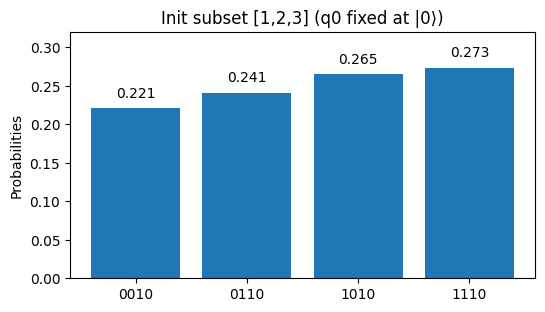

In [25]:
# We will initialize qubits [1,2,3] to an equal superposition of |001>, |011>, |101>, |111>.
# That's a 3-qubit statevector (length 8) with non-zeros at indices 1,3,5,7.
sv3 = np.array([0, 1, 0, 1, 0, 1, 0, 1]) / 2  # normalized (sum of squares = 1)

qc_init2 = QuantumCircuit(4, 4)   # 4 qubits, 4 classical bits
subset = [1, 2, 3]                # initialize these three; q0 remains |0>

# Initialize the subset; basis ordering corresponds to [q1, q2, q3] with q1 as LSB of the sv
qc_init2.initialize(sv3, subset)

# Barrier just for readability in the diagram (no functional effect)
qc_init2.barrier(range(4))

# Measure all qubits
qc_init2.measure(range(4), range(4))

print("Decomposed circuit for partial (3/4) initialize:")
print(qc_init2.decompose().draw(fold=120))

# Run and plot
counts_subset = run_counts(qc_init2)
print("Counts:", counts_subset)
plot_probs(counts_subset, "Init subset [1,2,3] (q0 fixed at |0⟩)")

# Expect ~25% weight on the four bitstrings with rightmost bit 0 (q0 is |0>):
# typically: '0010', '0110', '1010', '1110' (ordering may differ)


Decomposed circuit for partial init + global X:
                                                          ░ ┌───────────┐┌─┐         
q_0: ─────────────────────────────────────────────────────░─┤ U3(π,0,π) ├┤M├─────────
          ┌─────────────────────────────────────────────┐ ░ ├───────────┤└╥┘┌─┐      
q_1: ─|0>─┤0                                            ├─░─┤ U3(π,0,π) ├─╫─┤M├──────
          │                                             │ ░ ├───────────┤ ║ └╥┘┌─┐   
q_2: ─|0>─┤1 State Preparation(0,0.5,0,0.5,0,0.5,0,0.5) ├─░─┤ U3(π,0,π) ├─╫──╫─┤M├───
          │                                             │ ░ ├───────────┤ ║  ║ └╥┘┌─┐
q_3: ─|0>─┤2                                            ├─░─┤ U3(π,0,π) ├─╫──╫──╫─┤M├
          └─────────────────────────────────────────────┘ ░ └───────────┘ ║  ║  ║ └╥┘
c: 4/═════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                          0  1  2  3 
Counts

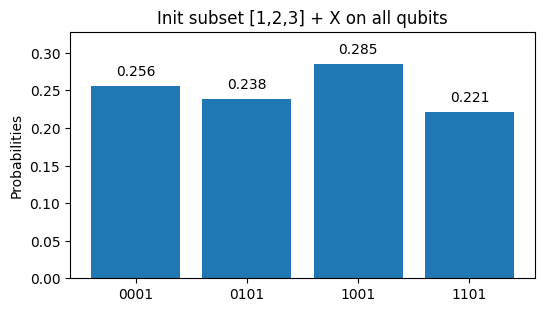

In [26]:
# Reuse the same 3-qubit state and subset
qc_init_x = QuantumCircuit(4, 4)
qc_init_x.initialize(sv3, [1, 2, 3])
qc_init_x.barrier(range(4))

# Apply an X to every qubit AFTER initialization to flip bits 0↔1
for q in range(4):
    qc_init_x.x(q)

qc_init_x.measure(range(4), range(4))

print("Decomposed circuit for partial init + global X:")
print(qc_init_x.decompose().draw(fold=120))

# Run and plot
counts_flipped = run_counts(qc_init_x)
print("Counts:", counts_flipped)
plot_probs(counts_flipped, "Init subset [1,2,3] + X on all qubits")

# Expect roughly the bit-flipped set of strings from Cell 3,
# e.g., '0010'→'1101', '0110'→'1001', '1010'→'0101', '1110'→'0001' (order may vary)
